In [21]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, classification_report

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Rescaling

from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical

import gc

!pip3 install --upgrade gdown

In [22]:
!gdown 14xGy4xfX5FWyQ3voGb9xSvF_eSj6-D3x

Downloading...
From: https://drive.google.com/uc?id=14xGy4xfX5FWyQ3voGb9xSvF_eSj6-D3x
To: /Users/holmes/Cloned_repo/predict-tourist-attraction/tourist_attraction_dataset_224.zip
100%|██████████████████████████████████████| 1.23G/1.23G [00:24<00:00, 50.8MB/s]


In [24]:
!mkdir -p data
!unzip tourist_attraction_dataset_224.zip -d data

Archive:  tourist_attraction_dataset_224.zip
   creating: data/tourist_attraction_dataset_224/
   creating: data/tourist_attraction_dataset_224/14754801502801197187/
   creating: data/tourist_attraction_dataset_224/14754801502801197187/00000000.shard/
  inflating: data/tourist_attraction_dataset_224/14754801502801197187/00000000.shard/00000000.snapshot  
  inflating: data/tourist_attraction_dataset_224/dataset_spec.pb  
 extracting: data/tourist_attraction_dataset_224/snapshot.metadata  


In [16]:
resolution = 224
num_classes = 20

path = "data/tourist_attraction_dataset_224"

dataset = tf.data.Dataset.load(path=path)

dataset

<_LoadDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
# Use 70-15-15 portion
num_examples = len(dataset)
num_train = int(num_examples * 0.7)
num_val = int(num_examples * 0.15)
num_test = num_examples - num_train - num_val

# Split the dataset into training, validation, and test sets
train_dataset = dataset.take(num_train)
val_dataset = dataset.skip(num_train).take(num_val)
test_dataset = dataset.skip(num_train + num_val).take(num_test)

# To free up the memory
del dataset
gc.collect

<function gc.collect(generation=2)>

In [18]:
# Convert the dataset to NumPy arrays
x_train, y_train = [], []
x_val, y_val = [], []
x_test, y_test = [], []

def tf_ds_to_numpy(dataset, x, y):
    for batch in dataset.as_numpy_iterator():
        x_temp, y_temp = batch
        x.append(x_temp)
        y.append(y_temp)
    
    # Convert the lists to NumPy arrays
    x = np.concatenate(x, axis=0)
    y = np.concatenate(y, axis=0)
    
    return x, y
    
x_train, y_train = tf_ds_to_numpy(train_dataset, x_train, y_train)
x_val, y_val = tf_ds_to_numpy(val_dataset, x_val, y_val)
x_test, y_test = tf_ds_to_numpy(test_dataset, x_test, y_test)

del train_dataset
del val_dataset
del test_dataset

gc.collect()

110

In [19]:
class_names = ['ancient_city_(mueang_boran)', 'big_buddha_phuket', 'big_buddha_temple_(wat_phra_yai)', 
               'chaithararam_temple_(wat_chalong)', 'chinatown_-_bangkok', 'historic_city_of_ayutthaya', 
               'jim_thompson_house', 'sukhothai_historical_park', 'temple_of_dawn_(wat_arun)', 'temple_of_the_emerald_buddha_(wat_phra_kaew)', 
               'temple_of_the_golden_buddha_(wat_traimit)', 'the_golden_mount_(wat_saket)', 'the_grand_palace', 'the_sanctuary_of_truth', 
               'tiger_cave_temple_(wat_tham_suea)', 'wat_chedi_luang_varavihara', 'wat_phra_chetuphon_(wat_pho)', 'wat_phra_singh', 'wat_rong_khun', 'wat_umong']

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5952, 224, 224, 3), (1290, 224, 224, 3), (5952,), (1290,))

In [20]:
train_classes, train_counts = np.unique(y_train, return_counts=True)
print('train class: ', train_classes)
print('train count: ', train_counts)
val_classes, val_counts = np.unique(y_val, return_counts=True)
print('val class: ', val_classes)
print('val count: ', val_counts)
test_classes, test_counts = np.unique(y_test, return_counts=True)
print('test class: ', test_classes)
print('test count: ', test_counts)

train class:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
train count:  [556 249 242 183 234 359 358 311 229 364 250 174 209 368 255 247 368 299
 450 247]
val class:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
val count:  [126  53  52  39  50  63  71  71  63  72  59  35  46  78  54  49  72  62
  81  52]
test class:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
test count:  [121  52  57  46  48  80  57  78  78  81  58  32  48  61  57  50  74  71
  87  54]


In [21]:
x_train /= 255.0
x_val /= 255.0
x_test /= 255.0

x_train = x_train.reshape(-1, resolution, resolution, 3)
x_val = x_val.reshape(-1, resolution, resolution, 3)
x_test = x_test.reshape(-1, resolution, resolution, 3)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

## Example image from some of the classes

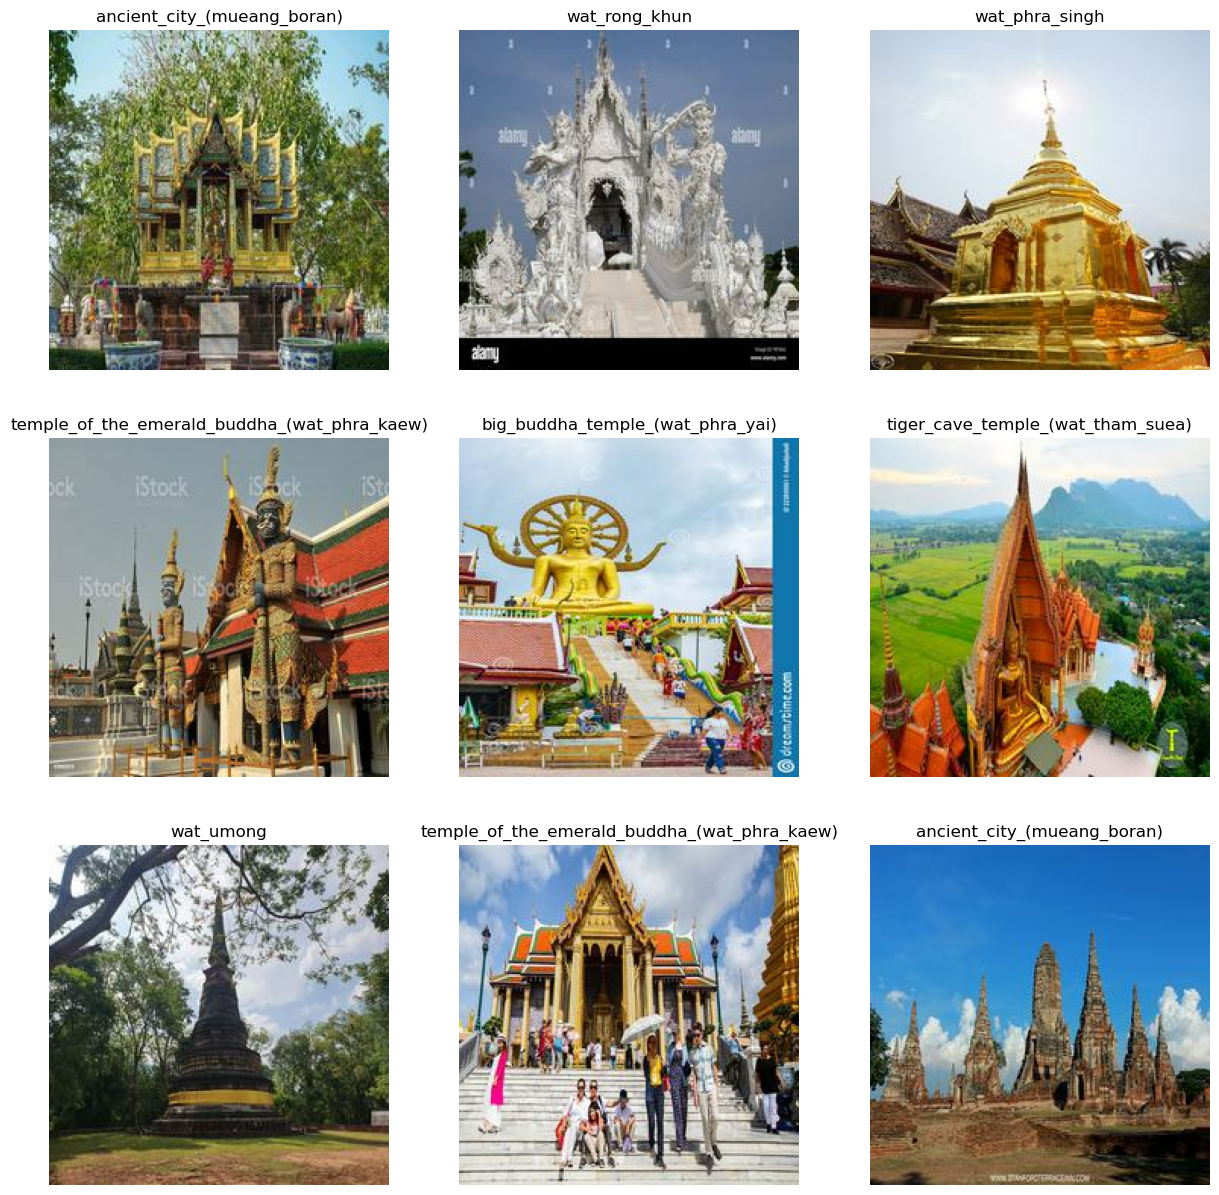

In [23]:
fig, axis = plt.subplots(3, 3, figsize=(15, 15))
for i, ax in enumerate(axis.flat):
    ax.imshow(x_train[i])
    label = class_names[y_train[i].argmax()]
    ax.set(title = f"{label}");
    ax.set_axis_off()

# Model use for identify location name in the picture

In [24]:
num_classes = 20

model = tf.keras.Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(resolution, resolution, 3)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                        

# Preparing Data Augmentation(ImageDataGenerator) and Confusion Matrix

In [28]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


train_gen = datagen.flow(x_train, y_train, batch_size=32)

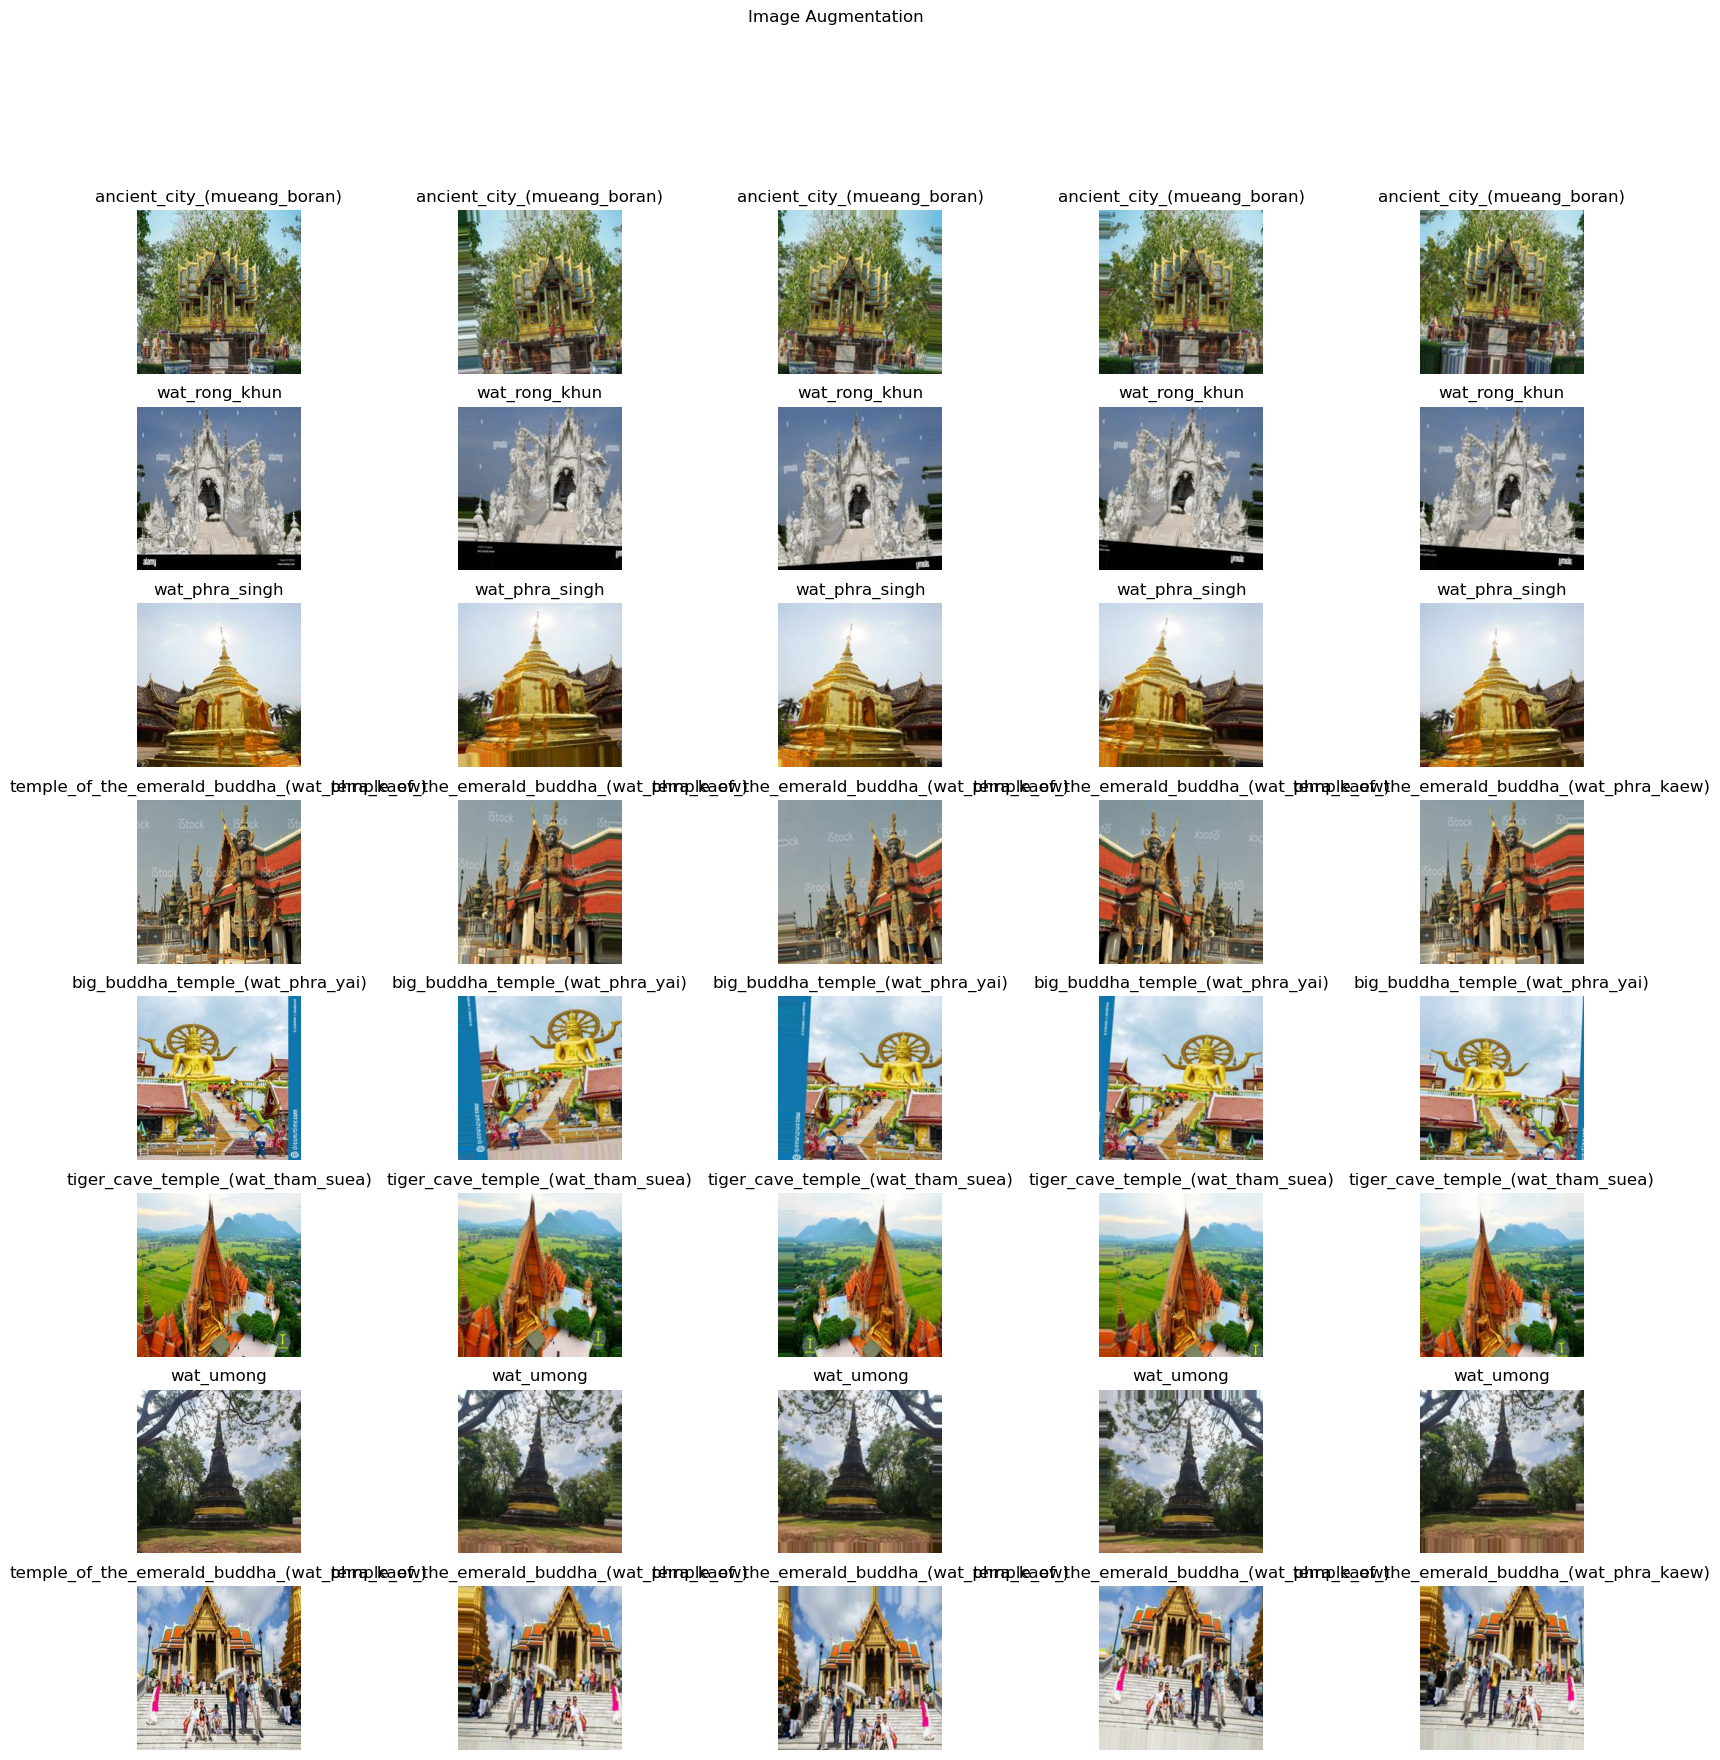

In [29]:
n_rows, n_cols = 8, 5

fig = plt.figure(figsize=(20, 20))
fig.suptitle("Image Augmentation")

for i in range(0, n_rows):
  image = np.expand_dims(x_train[i], axis=0)
  label = class_names[np.argmax(y_train[i])]

  it = datagen.flow(image, batch_size=1)
  for j in range(0, n_cols):
    ax = plt.subplot(n_rows, n_cols, i*n_cols + j + 1)
    if j == 0:
      plt.imshow(image[0])
    else:
      batch = it.next()
      plt.imshow(batch[0])
    plt.title(label)
    plt.axis('off')
  # plt.tight_layout()
plt.show()

# Fitting Model / Plotting Graph / Confusion Matrix and Classification Report

In [31]:
epochs = 100
batch_size = 32

In [33]:
model_gen = model
history_gen = model_gen.fit(train_gen, 
                              epochs = epochs,
                              batch_size=batch_size, 
                              validation_data =(x_val, y_val))

Epoch 1/100


2023-03-13 05:00:45.324976: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


186/186 [==============================] - 91s 412ms/step - loss: 3.0857 - accuracy: 0.1893 - val_loss: 4.1673 - val_accuracy: 0.1010
Epoch 2/100
186/186 [==============================] - 74s 397ms/step - loss: 2.5265 - accuracy: 0.2816 - val_loss: 3.2771 - val_accuracy: 0.1819
Epoch 3/100
186/186 [==============================] - 75s 402ms/step - loss: 2.1036 - accuracy: 0.3896 - val_loss: 1.8274 - val_accuracy: 0.4287
Epoch 4/100
186/186 [==============================] - 74s 395ms/step - loss: 1.9656 - accuracy: 0.4217 - val_loss: 1.7010 - val_accuracy: 0.4800
Epoch 5/100
186/186 [==============================] - 75s 401ms/step - loss: 1.8198 - accuracy: 0.4654 - val_loss: 1.6553 - val_accuracy: 0.5120
Epoch 6/100
186/186 [==============================] - 76s 406ms/step - loss: 1.6538 - accuracy: 0.5032 - val_loss: 1.5030 - val_accuracy: 0.5296
Epoch 7/100
186/186 [==============================] - 74s 394ms/step - loss: 1.6921 - accuracy: 0.4926 - val_loss: 1.9758 - val_accurac

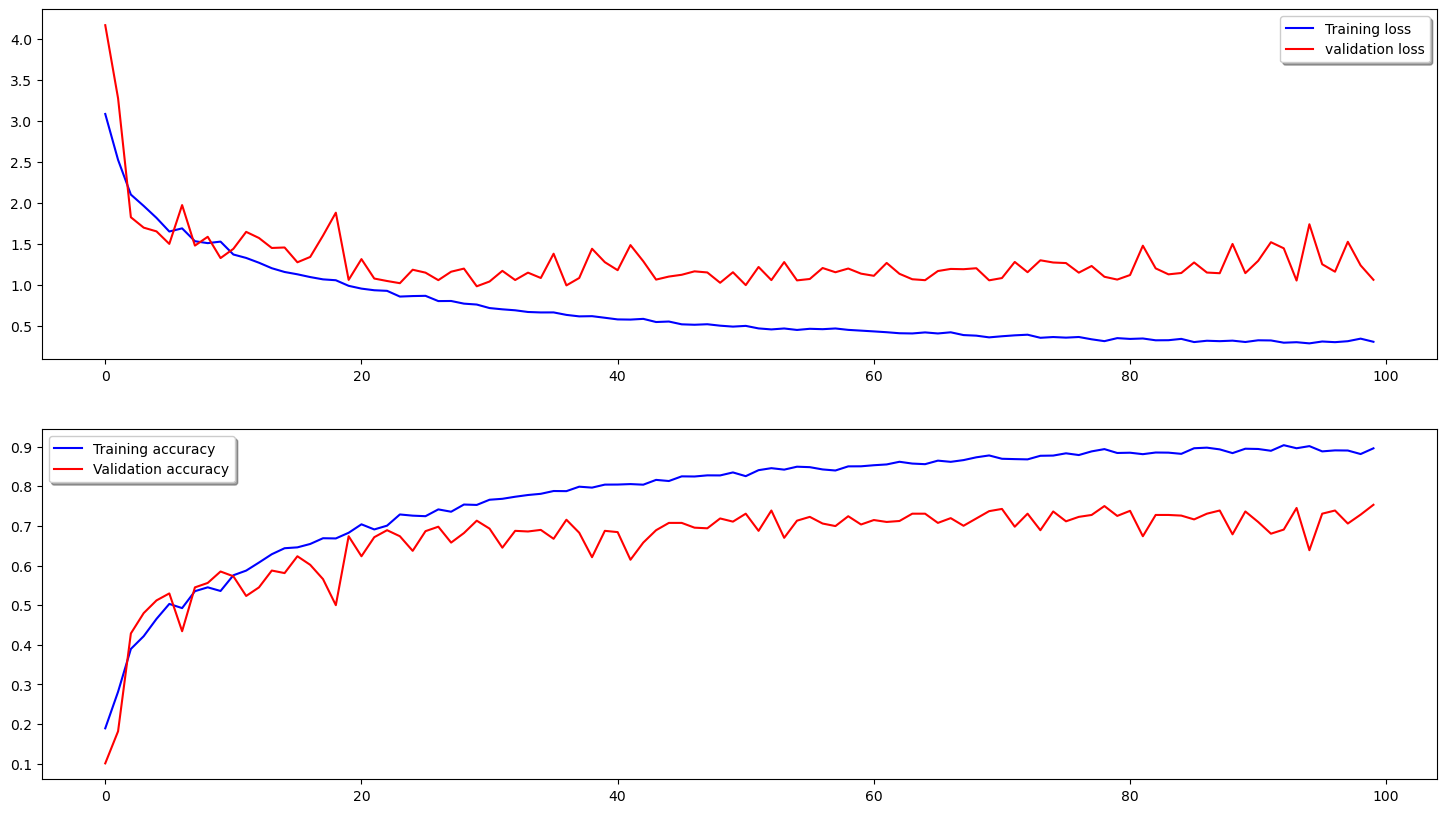

In [34]:
def plot(history):
  fig, ax = plt.subplots(2,1, figsize=(18, 10))
  ax[0].plot(history.history['loss'], color='b', label="Training loss")
  ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
  legend = ax[0].legend(loc='best', shadow=True)

  ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
  ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
  legend = ax[1].legend(loc='best', shadow=True)

plot(history_gen)

### Confusion Matrix and Classification Report of Fitting Model with ImageDataGenerator

In [35]:
def plot_confusion_matrix(cm, class_name, title="Confusion Matrix", cmap=None, normalize=False):
  if cmap is None:
    cmap = plt.get_cmap('Oranges')

  plt.figure(figsize=(10, 8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
    
  if class_name is not None:
      tick_marks = np.arange(len(class_name))
      plt.xticks(tick_marks, class_name, rotation=90)
      plt.yticks(tick_marks, class_name)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                   horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(cm[i, j]),
                   horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylim(len(class_name)-0.5, -0.5)
  plt.ylabel('True labels')
  plt.xlabel('Predicted labels')
  plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
  plt.show()

In [36]:
y_predict_gen = model_gen.predict(x_test)

y_true_gen = [np.argmax(i) for i in y_test]
y_predict_gen = [np.argmax(i) for i in y_predict_gen]
cm_gen = confusion_matrix(y_true_gen, y_predict_gen)

41/41 [==============================] - 2s 44ms/step


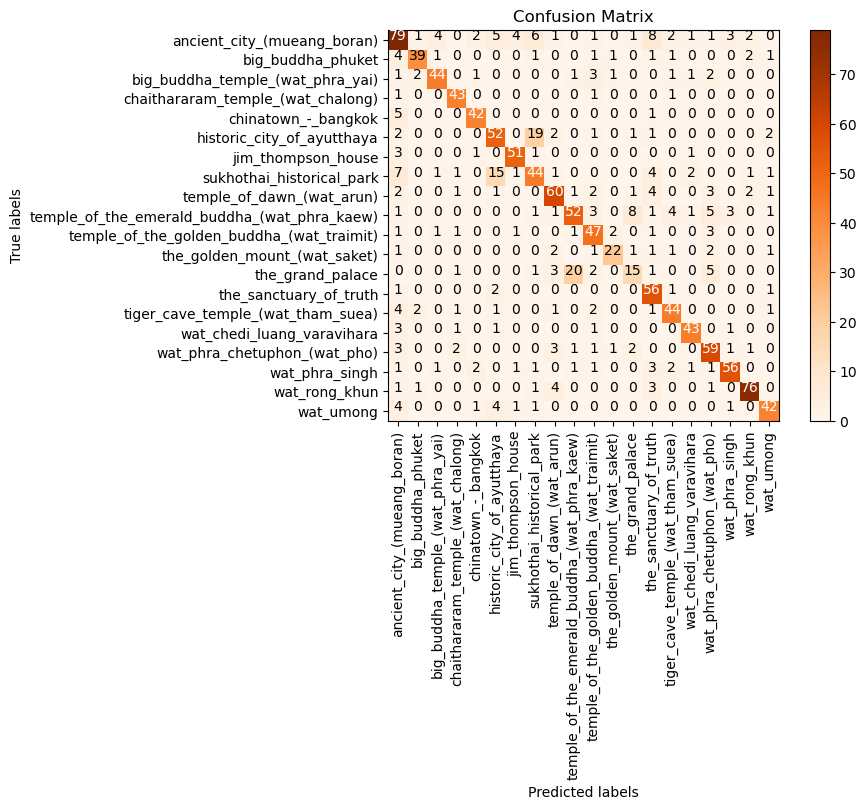

In [37]:
plot_confusion_matrix(cm_gen, class_names)

In [38]:
cr = classification_report(y_true_gen, y_predict_gen, target_names=class_names, digits=4, output_dict=True)
for class_name in class_names:
  print(class_name)
  print("Precision:", cr[class_name]["precision"])
  print("Recall:", cr[class_name]["recall"])
  print("F1-score:", cr[class_name]["f1-score"])
  print("Support:", cr[class_name]["support"])
  print("----------------------------------------------------")

ancient_city_(mueang_boran)
Precision: 0.6370967741935484
Recall: 0.6528925619834711
F1-score: 0.6448979591836735
Support: 121
----------------------------------------------------
big_buddha_phuket
Precision: 0.8666666666666667
Recall: 0.75
F1-score: 0.8041237113402062
Support: 52
----------------------------------------------------
big_buddha_temple_(wat_phra_yai)
Precision: 0.8461538461538461
Recall: 0.7719298245614035
F1-score: 0.8073394495412844
Support: 57
----------------------------------------------------
chaithararam_temple_(wat_chalong)
Precision: 0.8431372549019608
Recall: 0.9347826086956522
F1-score: 0.8865979381443299
Support: 46
----------------------------------------------------
chinatown_-_bangkok
Precision: 0.8571428571428571
Recall: 0.875
F1-score: 0.8659793814432989
Support: 48
----------------------------------------------------
historic_city_of_ayutthaya
Precision: 0.6419753086419753
Recall: 0.65
F1-score: 0.6459627329192547
Support: 80
---------------------------

In [39]:
from keras.models import load_model
model.save('model_224_kaggle.h5')